In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = pd.to_datetime(session.query(Measurement.date).order_by(Measurement.date.desc()).first())

year=(latest_date.year)
#year
month=latest_date.month
#month
day=latest_date.day
#day

# Calculate the date 1 year ago from the last data point in the database
date_oneYearAgo= dt.date(year[0],month[0], day[0]) - dt.timedelta(days=365)

date_oneYearAgo

datetime.date(2016, 8, 23)

In [12]:
# date_oneYearAgo

# Perform a query to retrieve the data and precipitation scores
# prcp_scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()
# prcp_scores
# date_prcp
date_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date_oneYearAgo).\
    order_by(Measurement.date).all()
#date_prcp

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

prcp_df = pd.DataFrame(date_prcp, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.sort_values('Date')
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


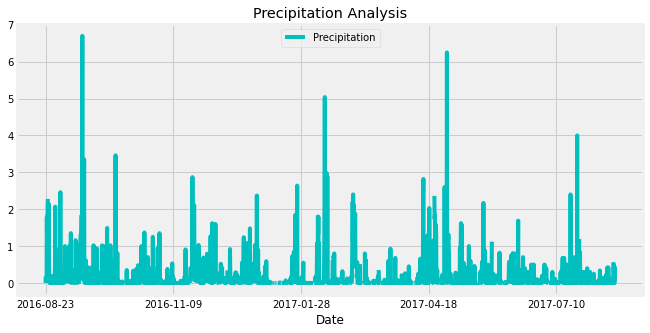

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation Analysis", figsize=(10,5), color='c')
plt.legend(loc='upper center')
plt.savefig("img/precipitation.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_cnt = session.query(Station.station).distinct().count()
station_cnt

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
most_active_stations

('USC00519281', 2772)

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

min_max_avg_temp = session.query(*sel).\
    filter(Measurement.station == "USC00519281").all()
min_max_avg_temp


[(54.0, 85.0, 71.66378066378067)]

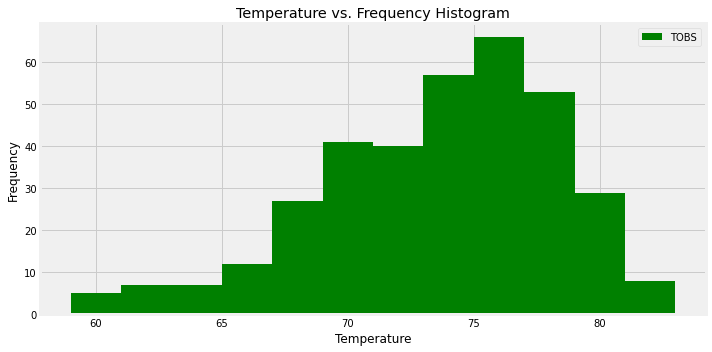

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= date_oneYearAgo).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

# Save the Query Results as a Pandas DataFrame
tobs_data_df = pd.DataFrame(tobs_data, columns=["TOBS"])

# Plot the Results as a Histogram with `bins=12`
tobs_data_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(10,5),color='g')
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("img/Temperature_vs_Frequency.png")
plt.show()


## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date='2017-02-28'
end_date='2017-03-05'

trip = calc_temps(start_date, end_date)
trip

[(64.0, 72.02777777777777, 78.0)]

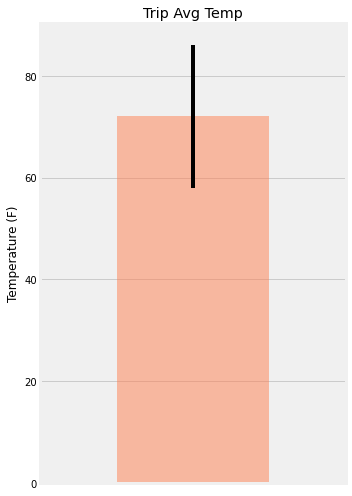

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip, columns=["TMIN", "TAVG", "TMAX"])

trip_df.plot.bar(y="TAVG", yerr=(trip_df["TMAX"] - trip_df["TMIN"]), 
                    title="Trip Avg Temp", color="coral", 
                    alpha=0.5, figsize=(5,7), legend=None)
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("img/trip_average_temperature.png")
plt.show()


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date='2017-02-28'
end_date='2017-03-05'


total_prcp_by_st=(session.query(Measurement.station,Station.name,func.sum(Measurement.prcp),
                                Station.latitude,Station.longitude,Station.elevation)
                         .filter(Measurement.date >= start_date)
                         .filter(Measurement.date <= end_date)
                         .filter(Measurement.station == Station.station)
                         .group_by(Measurement.station)
                         .order_by(func.sum(Measurement.prcp)
                         .desc())
                         .all())
total_prcp_by_st

[('USC00519281',
  'WAIHEE 837.5, HI US',
  4.720000000000001,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 4.45, 21.4234, -157.8015, 14.6),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  4.07,
  21.3331,
  -157.8025,
  152.4),
 ('USC00517948', 'PEARL CITY, HI US', 2.98, 21.3934, -157.9751, 11.9),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  2.7399999999999998,
  21.2716,
  -157.8168,
  3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  2.32,
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  1.1600000000000001,
  21.5213,
  -157.8374,
  7.0)]

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
trip_dates=['02-28','03-01','03-02','03-03','03-04', '03-05']

normals=[]

# Loop through the list of %m-%d strings and calculate the normals for each date

for i in trip_dates:
    normals.append(daily_normals(i)[0])

normals


[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


trip_daily_normals_df=pd.DataFrame(normals,columns=['Temp_MIN','Temp_AVG','Temp_MAX'],
                                   index=trip_dates)

trip_daily_normals_df.index.name='date'
trip_daily_normals_df


,Temp_MIN,Temp_AVG,Temp_MAX
date,,,
02-28,65.0,70.655172,80.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


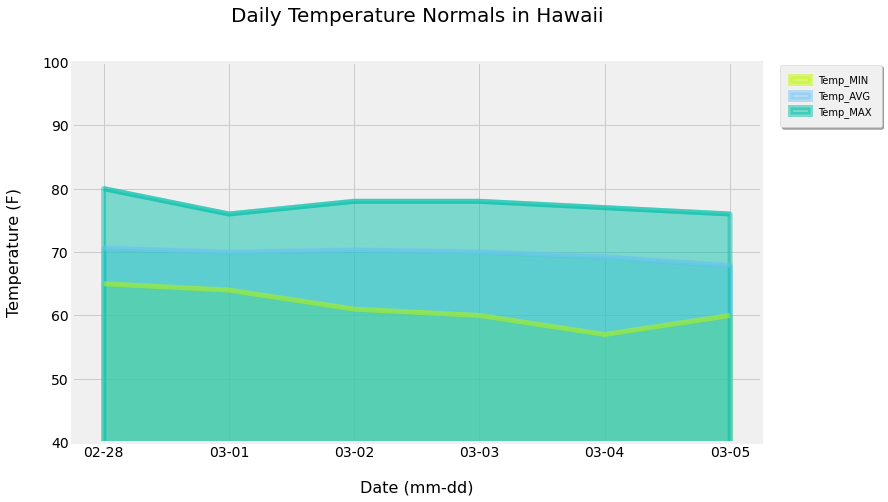

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
plt.rcParams['figure.figsize']=(11,7)
colors=['xkcd:chartreuse','xkcd:lightblue','xkcd:turquoise']

trip_daily_normals_df.plot.area(linewidth=5,stacked=False,rot=0,alpha=0.5,color=colors);


plt.ylim(40,100)
plt.yticks(size=14)
plt.xticks(fontsize=14)
plt.xlabel('Date (mm-dd)',fontsize=16,color='black',labelpad=20)
plt.ylabel('Temperature (F)',fontsize=16,color='black',labelpad=20)
plt.title('Daily Temperature Normals in Hawaii',fontsize=20,pad=40)
plt.gca().legend(loc='center left', bbox_to_anchor=(1.02, 0.91),shadow=True,borderpad=1);
plt.savefig("img/Daily_temperature_normals.png")
